### import libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import georaster
from osgeo import gdal
from shapely.geometry import Point
import richdem as rd
import geopandas as gpd
from pyproj import CRS
import gdal
from rasterio.mask import mask
from rasterio.windows import Window

%matplotlib inline

### Use Rasterio to open data

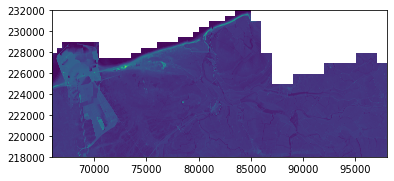

<AxesSubplot:>

In [2]:
fp = r'/Users/nicolasdemuynck/Downloads/DHMVIIDTMRAS1m_k05/GeoTIFF/DHMVIIDTMRAS1m_k05.tif'
img = rasterio.open(fp)
show(img)

### Image related data

In [3]:
dataset = img
print (dataset.count) # number of bands
print (dataset.height, dataset.width) # Image resolution
print (dataset.crs) # coordinate reference system : Lambert 72

1
14000 32000
LOCAL_CS["Belge 1972 / Belgian Lambert 72",GEOGCS["Belge 1972",DATUM["unknown",SPHEROID["unretrievable - using WGS84",6378137,298.257223563],TOWGS84[-106.869,52.2978,-103.724,0.3366,-0.457,1.8422,-1.2747]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],AUTHORITY["EPSG","31370"],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


### Using georaster

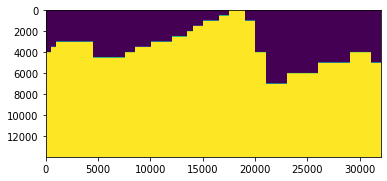

In [4]:
# Use SingleBandRaster() if image has only one band
img = georaster.MultiBandRaster('/Users/nicolasdemuynck/Downloads/DHMVIIDTMRAS1m_k05/GeoTIFF/DHMVIIDTMRAS1m_k05.tif')
# img.r gives the raster in [height, width, band] format 
# band no. starts from 0
plt.imshow(img.r[:,:,0])

### Plotting image with GDAL

In [5]:
dataset = gdal.Open('/Users/nicolasdemuynck/Downloads/DHMVIIDTMRAS1m_k05/GeoTIFF/DHMVIIDTMRAS1m_k05.tif', gdal.GA_ReadOnly) 

In [30]:
# Note GetRasterBand() takes band no. starting from 1 not 0
band = dataset.GetRasterBand(1)

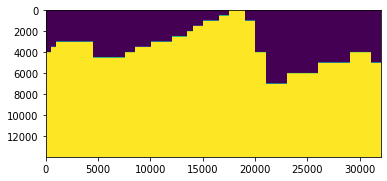

In [31]:
arr = band.ReadAsArray()
plt.imshow(arr)

### DEM raster data analysis

In [6]:
# Create a rasterio dataset
img = rasterio.open('/Users/nicolasdemuynck/Downloads/DHMVIIDTMRAS1m_k05/GeoTIFF/DHMVIIDTMRAS1m_k05.tif')

In [7]:
# Get rasterio dataset's coordinate system
img.crs

CRS.from_wkt('LOCAL_CS["Belge 1972 / Belgian Lambert 72",GEOGCS["Belge 1972",DATUM["unknown",SPHEROID["unretrievable - using WGS84",6378137,298.257223563],TOWGS84[-106.869,52.2978,-103.724,0.3366,-0.457,1.8422,-1.2747]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],AUTHORITY["EPSG","31370"],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

In [8]:
CRS.from_epsg(4326) #WGS84 coordinates are provided in degrees in the common longitude and latitude def

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Get rasterio dataset's number of bands: each band represents a grayscale map for a specific wavelenght region
img.count
# NOte that rasterio starts counting bands at 2, unlike Python, for some reason

1

In [10]:
img.indexes #number of bands

(1,)

In [11]:
#get rasterio dataset's bounds
img.bounds

BoundingBox(left=66000.0, bottom=218000.0, right=98000.0, top=232000.0)

In [12]:
img.transform # x coordinate origin and y coordinate origin (dataset's crs coordinate origin)

Affine(1.0, 0.0, 66000.0,
       0.0, -1.0, 232000.0)

In [13]:
img.transform * (0,0) #coordinates of the upper left corner

(66000.0, 232000.0)

In [14]:
# get width and height in pixels: the differences between the bounds
raster_width = img.width
raster_height = img.height

In [15]:
print (raster_width)
print (raster_height) 

32000
14000


In [16]:
img.transform * (img.width, img.height) # these coordinate values are relative to the origin of the
#dataset's coordinate reference system

(98000.0, 218000.0)

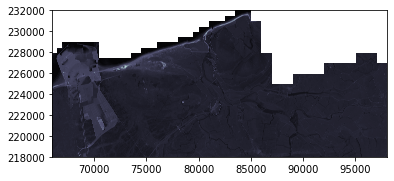

<AxesSubplot:>

In [52]:
# Plot the rasterio dataset, DEM
rasterio.plot.show (img, cmap = 'bone')

### Create a band1 object of the rasterio dataset

In [17]:
# bands in rasterio are numpy arrays
img_band1 = img.read(1).astype('float64')
img_band1

array([[-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       ...,
       [ 3.58999991e+00,  3.64000010e+00,  3.53999996e+00, ...,
         3.60999990e+00,  3.63000011e+00,  3.59999990e+00],
       [ 3.54999995e+00,  3.57999992e+00,  3.58999991e+00, ...,
         3.59999990e+00,  3.61999989e+00,  3.60999990e+00],
       [ 3.56999993e+00,  3.54999995e+00,  3.63000011e+00, ...,
         3.61999989e+00,  3.58999991e+00,  3.61999989e+00]])

In [18]:
# Get pixel value by passing row & col from band1
img_band1[0,0]

-9999.0

### Get longitude & latitude coordinates by passing row & col from the rasterio dataset

In [19]:
# you can not get longitude & latitude coordinates from a rasterio band since it is only a numpy array
img.xy(0,0)

(66000.5, 231999.5)

### Create a richdem object using rasterio band1

In [20]:
img_richdem = rd.rdarray(img_band1, no_data=-9999)

### Plot the richdem object

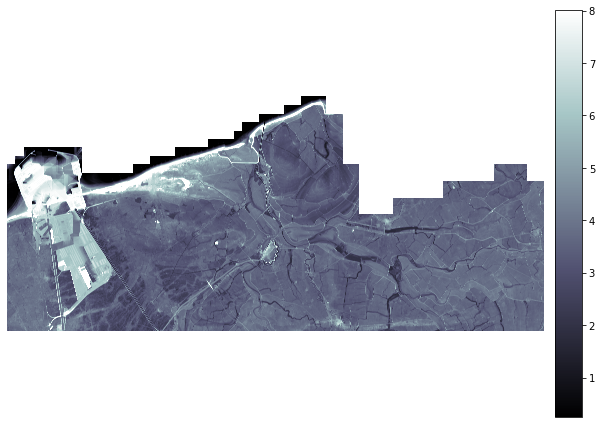

{'vmin': 0.2524882829189301, 'vmax': 8.010000228881836}

In [21]:
rd.rdShow(img_richdem, axes = False, cmap = 'bone', figsize = (9,6))
#shows minimum and maximum elevation
# in km

### Create slope raster

In [63]:
img_slope = rd.TerrainAttribute(img_richdem, attrib = 'slope_degrees')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


### Plot slope values

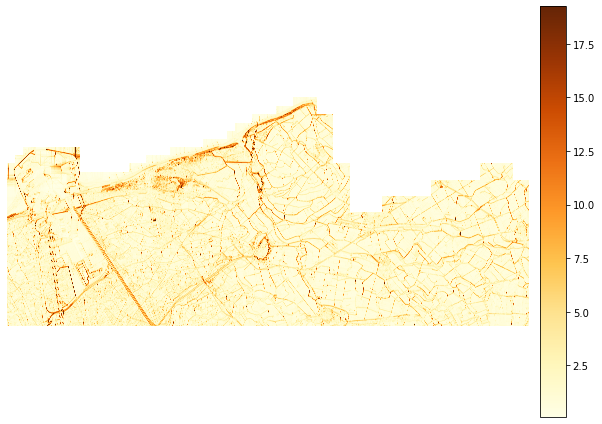

{'vmin': 0.10128538310527802, 'vmax': 19.239830017089844}

In [65]:
rd.rdShow(img_slope, axes = False, cmap= 'YlOrBr', figsize = (9,6))
# white values are flat
# Brown values are steep
# In metres

### Create aspect using richdem

In [66]:
img_aspect = rd.TerrainAttribute(img_richdem, attrib = 'aspect')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


### Plot the aspect values

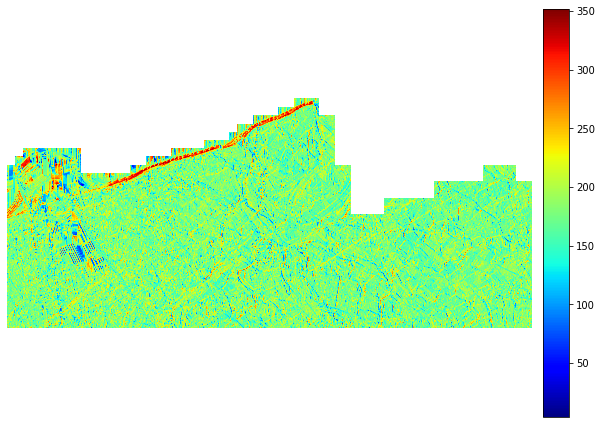

{'vmin': 4.214174270629883, 'vmax': 351.8699035644531}

In [67]:
rd.rdShow(img_aspect, axes = False, cmap = 'jet', figsize = (9,6))
# in degrees
# 270 degrees is a west direction
# 360 is north
# 180 is south
# 90 is east

### Generate a dictionary of the following lists: geometry point objects and the attributes

In [112]:
pnt_data = {'elevation':[],'slope':[],'aspect':[],'geometry':[]}

width_step = 1000
height_step = 1000

for i in range(0,raster_width,width_step):
    if i % 47 == 0 and i != 0:
        for j in range(200,raster_height-height_step,height_step):
            pnt_data['elevation'].append(round(img_richdem[i,j],2))
            pnt_data['slope'].append(round(img_slope[i,j],2))
            pnt_data['aspect'].append(round(img_aspect[i,j],2))
            pnt_data['geometry'].append(Point(img.xy(i,j)))

### Create a geopandas dataframe from the Geotiff file

In [103]:
crs = {'init' : 'epsg:4326'}
gp_df = gpd.GeoDataFrame(pnt_data, crs=crs)
gp_df

/opt/anaconda3/envs/Levon_Env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,elevation,slope,aspect,geometry


### Export the geopandas dataframe to geojson

In [91]:
#gp_df.to_file('./gp_df.geojson', driver = "GeoJSON")

### Export the geopandas dataframe to shapefile

In [90]:
#gp_df.to_file('./gp_df.shp', driver = "ESRI Shapefile")

### Windowed reading and writing

In [24]:
img.height

14000

In [42]:
img.count

1

In [27]:
img.width

32000

In [37]:
from rasterio.windows import Window

new_img = Window.from_slices(slice(4000, -4000), slice(4000, -4000), height = img.height, width=img.width)
new_img

Window(col_off=4000, row_off=4000, width=24000, height=6000)

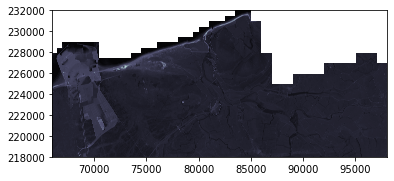

<AxesSubplot:>

In [36]:
rasterio.plot.show (img, cmap = 'bone')

In [39]:
w = img.read(1, window=Window(0, 0, 512, 256))
print(w.shape)

(256, 512)


In [50]:
image = np.ones((150, 250), dtype=rasterio.ubyte) * 127

with rasterio.open(
        '/Users/nicolasdemuynck/Downloads/DHMVIIDTMRAS1m_k05/GeoTIFF/DHMVIIDTMRAS1m_k05.tif', 'w',
        driver='GTiff', width=32000, height=14000, count=1,
        dtype=image.dtype) as dst:
    dst.write(image, window=Window(3200, 1400, 12000, 7000), indexes=1)

In [61]:
dst

<closed DatasetWriter name='/Users/nicolasdemuynck/Downloads/DHMVIIDTMRAS1m_k05/GeoTIFF/DHMVIIDTMRAS1m_k05.tif' mode='w'>

In [62]:
img.transform

Affine(1.0, 0.0, 66000.0,
       0.0, -1.0, 232000.0)

In [63]:
img.bounds

BoundingBox(left=66000.0, bottom=218000.0, right=98000.0, top=232000.0)

In [67]:
img.window

<bound method WindowMethodsMixin.window of <open DatasetReader name='/Users/nicolasdemuynck/Downloads/DHMVIIDTMRAS1m_k05/GeoTIFF/DHMVIIDTMRAS1m_k05.tif' mode='r'>>

### Get to see the specs of the window

In [70]:
from rasterio.windows import get_data_window
window = get_data_window(img.read(1, masked=True))
window

Window(col_off=0, row_off=0, width=32000, height=14000)

In [82]:
import rasterio
from rasterio.windows import Window
win = Window(-60000, 200000, 6000, 32000)

img_transform = img.transform
win_transform = img.window_transform(win)
    
print(img_transform)
print(win_transform)

| 1.00, 0.00, 66000.00|
| 0.00,-1.00, 232000.00|
| 0.00, 0.00, 1.00|
| 1.00, 0.00, 6000.00|
| 0.00,-1.00, 32000.00|
| 0.00, 0.00, 1.00|


In [84]:
win_transform

Affine(1.0, 0.0, 6000.0,
       0.0, -1.0, 32000.0)

In [85]:
img_transform

Affine(1.0, 0.0, 66000.0,
       0.0, -1.0, 232000.0)

In [86]:
img.width

32000

In [87]:
img.height

14000

In [88]:
w = img.read(1, window = Window(img.width/2, img.height/2, img.width/7, img.height/7))
w

array([[3.71, 3.72, 3.77, ..., 3.59, 3.54, 3.54],
       [3.72, 3.75, 3.81, ..., 3.55, 3.58, 3.54],
       [3.72, 3.75, 3.78, ..., 3.55, 3.51, 3.56],
       ...,
       [6.67, 6.68, 6.64, ..., 4.03, 4.06, 4.04],
       [6.64, 6.59, 6.62, ..., 4.05, 4.03, 4.05],
       [6.54, 6.56, 6.57, ..., 4.04, 4.03, 4.04]], dtype=float32)

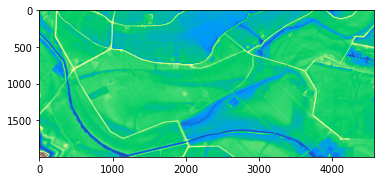

<AxesSubplot:>

In [89]:
rasterio.plot.show (w, cmap = 'terrain')